In [3]:
import ROOT
import os
import time
import matplotlib.pyplot as plt
import csv

Welcome to JupyROOT 6.24/06


In [4]:
path = "../merged/"

In [5]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))
    total_size = sum([os.path.getsize(path + filenames[i]) for i in range(n_files)])
    return total_size / (2**30)

In [6]:
def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

In [7]:
def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]
    

In [8]:
def runtime_measure(path, n_files):
    # Specify the number of threads
    ROOT.ROOT.EnableImplicitMT()
    
    # Get paths to all the files to be read 
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(n_files):
        files_to_read.push_back(path + filenames[i])
    
    # Measure runtime
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    np_array = cut.AsNumpy(["candidate_vMass"])
    runtime = time.time() - start_time
    
    return runtime
    

In [9]:
import multiprocessing
import numpy as np
import concurrent.futures

In [10]:
def to_numpy(files, result):
    if files.empty(): return
#     ROOT.ROOT.DisableImplicitMT()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])


In [178]:
def partition_files(path, n_files, n_processes):
    filenames = sorted(os.listdir(path))
    partitions = []
    sizes = []
    temp = 0
    for i in range(n_processes):
        if i >= n_files: break
        n_files_in_partition = n_files // n_processes if i >= n_files % n_processes else n_files // n_processes + 1
        files_to_read = ROOT.std.vector('string')()
        partition_size = 0
        for j in range(n_files_in_partition):
            files_to_read.push_back(path + filenames[temp + j])
            partition_size += os.path.getsize(path + filenames[temp + j]) / 2**30
        temp += n_files_in_partition
        partitions.append(files_to_read)
        sizes.append(partition_size)
    return partitions, sizes

In [28]:
partition_files(path, 10, 5)

([<cppyy.gbl.std.vector<string> object at 0x561c1c778410>,
  <cppyy.gbl.std.vector<string> object at 0x561c1c7a7c90>,
  <cppyy.gbl.std.vector<string> object at 0x561c1c7a7da0>,
  <cppyy.gbl.std.vector<string> object at 0x561c1a8c6310>,
  <cppyy.gbl.std.vector<string> object at 0x561c1ab2bef0>],
 [3.2835384970530868,
  4.541670988313854,
  4.207963943481445,
  3.867865301668644,
  3.6777110574766994])

In [29]:
def runtime_measure_mp(path, n_files, n_processes):
    # Measure runtime
    partitions, _ = partition_files(path, n_files, n_processes)
    start_time = time.time()
    processes = []
    result = multiprocessing.Manager().list()
    for partition in partitions:
        p = multiprocessing.Process(target=to_numpy, args=[partition, result])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    np.concatenate(tuple(result))
    runtime = time.time() - start_time
    
    return runtime


In [13]:
def to_numpy1(rdf, result):
    cut = rdf.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])

In [14]:
def runtime_measure_mp1(path, n_files, n_processes):
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(n_files):
        files_to_read.push_back(path + filenames[i])
        
    start_time = time.time()
    processes = []
    result = multiprocessing.Manager().list()
    for i in range(n_processes):
        rdf = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read).Range(i, 0, n_processes)
        p = multiprocessing.Process(target=to_numpy1, args=[rdf, result])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    np.concatenate(tuple(result))
    runtime = time.time() - start_time
    
    return runtime
# , np.concatenate(tuple(result))

In [163]:
runtime_measure_mp1(path, 4, 4)

53.129727363586426

In [173]:
runtime_measure_mp(path, 60, 60)

42.70807123184204

In [15]:
def runtime_vs_size(path, n_threads, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_%d_%d_%d_%d.csv" % (target_dir, n_threads, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure(path, i, n_threads) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)


In [16]:
def runtime_vs_size_plot(path, n_threads, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_%d_%d_%d_%d.csv" % (target_dir, n_threads, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size(path, n_threads, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Size (%d threads)' % (n_threads))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data), yerr=col_standard_deviation(data), fmt="o", ecolor="orange")
        plt.savefig('figures/rdf/%s/runtime_vs_size_%d_%d_%d_%d.png' % (target_dir, n_threads, max_files, step, n_loops), bbox_inches='tight')


In [17]:
def runtime_vs_threads(path, n_files, max_threads, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_rdf/%s/runtime_vs_threads_%d_%d_%d_%d.csv" % (target_dir, n_files, max_threads, step, n_loops))
    x = [a for a in range(step, max_threads + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure(path, n_files, i) for i in range(step, max_threads + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)
        

In [18]:
def runtime_vs_threads_plot(path, n_files, max_threads, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_threads_%d_%d_%d_%d.csv" % (target_dir, n_files, max_threads, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_threads(path, n_files, max_threads, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Threads (%.2f GB)' % (get_total_size(path, n_files)))
        plt.xlabel('Threads')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, max_threads + 1, step))
        plt.gca().set_ylim([0, 50])
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_threads_%d_%d_%d_%d.png' % (target_dir, n_files, max_threads, step, n_loops), bbox_inches='tight')

In [19]:
def runtime_vs_processes(path, n_files, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_rdf/%s/runtime_vs_processes_%d_%d_%d.csv" % (target_dir, n_files, step, n_loops))
    x = [a for a in range(step, n_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, n_files, i) for i in range(step, n_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [20]:
def runtime_vs_processes_plot(path, n_files, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_processes_%d_%d_%d.csv" % (target_dir, n_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_processes(path, n_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (20, 8))
        plt.title('Runtime vs Processes (%d files, %.2f GB)' % (n_files, get_total_size(path, n_files)))
        plt.xlabel('Processes')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, n_files + 1, step))
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_processes_%d_%d_%d.png' % (target_dir, n_files, step, n_loops), bbox_inches='tight')

In [21]:
def runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, i, n_processes) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [22]:
def runtime_vs_size_plot_mp(path, n_processes, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (20, 8))
        plt.title('Runtime vs Size (%d processes)' % (n_processes))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data[1:]), yerr=col_standard_deviation(data[1:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate("%.2f(%d)" % (round(col_average(data[1:])[i], 2), (i + 1) * step), (data[0][i], col_average(data[1:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.png' % (target_dir, n_processes, max_files, step, n_loops), bbox_inches='tight')

In [19]:
#runtime_vs_threads_plot(path, 10, 10, 1, 10, "merged")


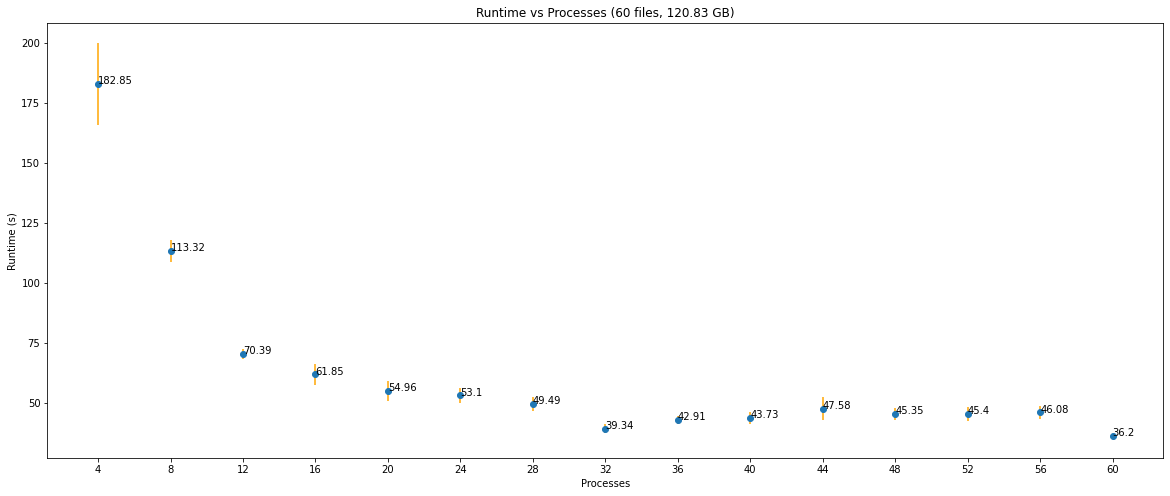

In [46]:
runtime_vs_processes_plot(path, 60, 4, 10, "merged")

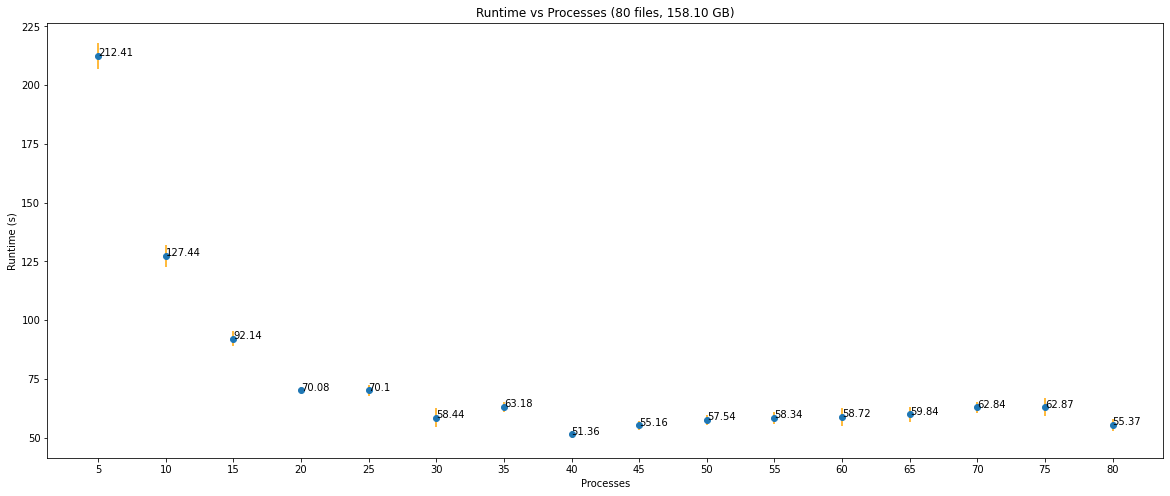

In [47]:
runtime_vs_processes_plot(path, 80, 5, 10, "merged")

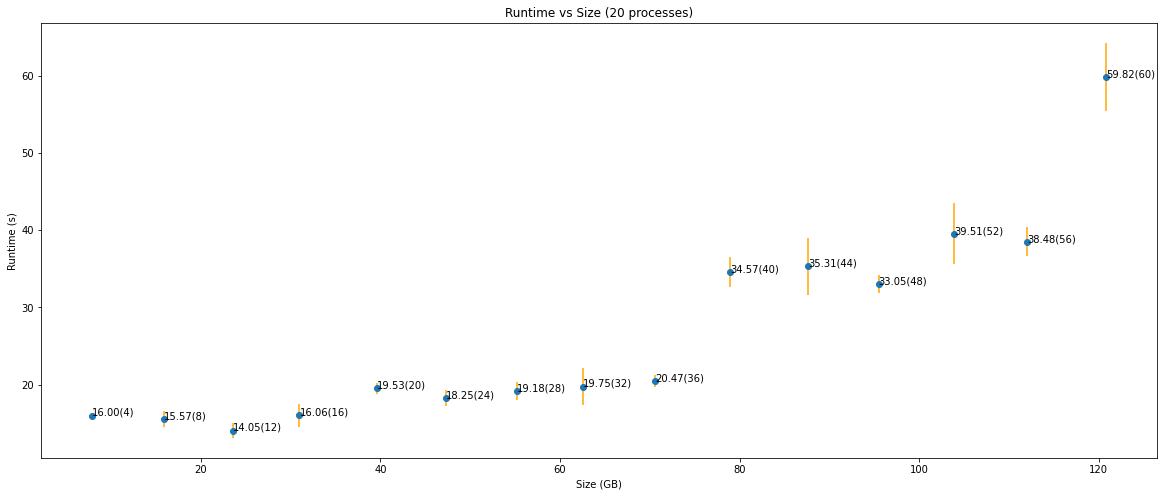

In [49]:
runtime_vs_size_plot_mp(path, 20, 60, 4, 10, "merged")

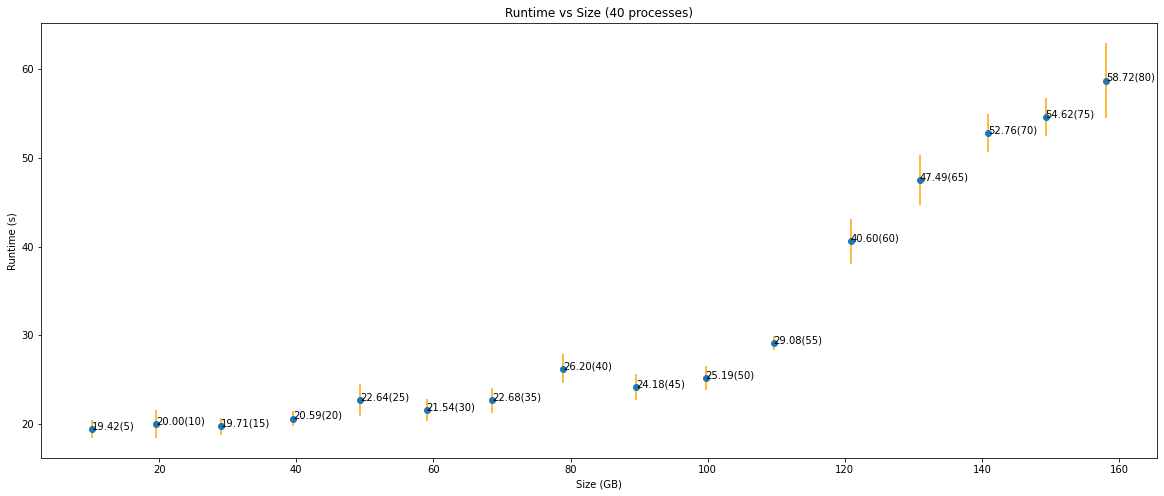

In [50]:
runtime_vs_size_plot_mp(path, 40, 80, 5, 10, "merged")

In [176]:
def to_numpy_detailed(files, size, index, result, process_runtimes):
    if files.empty(): return
    key = "P%d (%.2f GB)" % (index, size)
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])
    runtime = time.time() - start_time
    
    process_runtimes[key] = runtime
#     if key not in process_runtimes.keys():
#         process_runtimes[key] = [runtime]
#     else:
#         process_runtimes[key].append(runtime)

In [177]:
def runtime_measure_detailed(path, n_files, n_processes):
    partitions, sizes = partition_files(path, n_files, n_processes)
    start_time = time.time()
    processes = []
    result = multiprocessing.Manager().list()
    process_runtimes = multiprocessing.Manager().dict()
    for i in range(len(partitions)):
        p = multiprocessing.Process(target=to_numpy_detailed, args=[partitions[i], sizes[i], i, result, process_runtimes])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    start_concat = time.time()
    np.concatenate(tuple(result))
    concat_runtime = time.time() - start_concat
    
    runtime = time.time() - start_time
    
    return runtime, concat_runtime, dict(process_runtimes)

In [182]:
runtime_measure_detailed(path, 4, 4)

(8.360490322113037,
 0.027414321899414062,
 {'P0 (1.58 GB)': 5.019754648208618,
  'P1 (1.71 GB)': 5.294946670532227,
  'P2 (2.01 GB)': 6.094419240951538,
  'P3 (2.53 GB)': 7.727741003036499})

In [183]:
runtime_measure_detailed(path, 8, 8)

(7.608217477798462,
 0.04311490058898926,
 {'P0 (1.58 GB)': 5.312106370925903,
  'P1 (1.71 GB)': 5.400390386581421,
  'P7 (1.74 GB)': 5.063122510910034,
  'P5 (1.88 GB)': 5.876500844955444,
  'P2 (2.01 GB)': 6.200164794921875,
  'P6 (2.13 GB)': 6.144861698150635,
  'P4 (2.33 GB)': 6.902842998504639,
  'P3 (2.53 GB)': 7.047088861465454})

In [184]:
runtime_measure_detailed(path, 8, 4)

(13.248319387435913,
 0.024225950241088867,
 {'P0 (3.28 GB)': 9.875129222869873,
  'P3 (3.87 GB)': 11.09149432182312,
  'P2 (4.21 GB)': 11.549472332000732,
  'P1 (4.54 GB)': 12.748301267623901})

In [185]:
runtime_measure_detailed(path, 16, 16)

(8.889277935028076,
 0.11078381538391113,
 {'P12 (1.37 GB)': 4.210587739944458,
  'P0 (1.58 GB)': 5.181310415267944,
  'P1 (1.71 GB)': 5.562891483306885,
  'P9 (1.62 GB)': 5.243724346160889,
  'P7 (1.74 GB)': 5.6750569343566895,
  'P5 (1.88 GB)': 5.933375835418701,
  'P11 (1.92 GB)': 5.878897666931152,
  'P2 (2.01 GB)': 6.827112913131714,
  'P14 (2.02 GB)': 6.1722235679626465,
  'P4 (2.33 GB)': 7.070175647735596,
  'P6 (2.13 GB)': 7.006622552871704,
  'P8 (2.05 GB)': 6.977280855178833,
  'P15 (1.93 GB)': 6.808522939682007,
  'P3 (2.53 GB)': 7.751909255981445,
  'P13 (2.10 GB)': 7.133990526199341,
  'P10 (2.05 GB)': 7.635502576828003})

In [186]:
runtime_measure_detailed(path, 16, 8)

(13.329874515533447,
 0.04445457458496094,
 {'P6 (3.48 GB)': 9.668254137039185,
  'P0 (3.28 GB)': 10.578017950057983,
  'P3 (3.87 GB)': 10.798535108566284,
  'P4 (3.68 GB)': 11.139503002166748,
  'P5 (3.97 GB)': 11.202868223190308,
  'P7 (3.95 GB)': 11.064476728439331,
  'P2 (4.21 GB)': 12.151692867279053,
  'P1 (4.54 GB)': 12.836957454681396})